In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Copy data

In [5]:
# os.chdir('/content')

In [6]:
BASE_PATH_DATA = '/content/drive/MyDrive/ai/ycup21/data/'

In [7]:
!ls {BASE_PATH_DATA}

id_to_remove.npy     metadata.json	  ycup21-images-1.tgz
index_to_remove.npy  ycup21-datasets.tgz


In [8]:
%%time
file_name = 'ycup21-images-1.tgz'
file_path = BASE_PATH_DATA + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xf {local_path}

CPU times: user 144 ms, sys: 32.4 ms, total: 176 ms
Wall time: 20.2 s


# Install libs

In [9]:
!pip install pytorch-lightning
# !pip install jsonlines
!pip install hydra-core --upgrade
!pip install bpemb
!pip install segmentation_models_pytorch

     |████████████████████████████████| 925 kB 35.3 MB/s 
     |████████████████████████████████| 125 kB 57.0 MB/s 
     |████████████████████████████████| 282 kB 36.0 MB/s 
     |████████████████████████████████| 636 kB 42.1 MB/s 
     |████████████████████████████████| 829 kB 62.7 MB/s 
     |████████████████████████████████| 1.3 MB 31.9 MB/s 
     |████████████████████████████████| 160 kB 59.9 MB/s 
     |████████████████████████████████| 271 kB 60.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a6ba2a9a6ab64a1db496f804c81768737c20f012dcb920568a5d8b727de6e0d4
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

     |████████████████████████████████| 1.2 MB 38.7 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
     |████████████████████████████████| 376 kB 50.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=a3b0b3af5b9fc3815384276614852ac747cfe942c7057114184b7bec0a7f5d9d
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e6eb8522ad0deb298d59d7f53cd6e18b845993d44759e0154d2ec813d29c5517
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Imports

In [3]:
import os

In [4]:
# BASE_PATH = '/content/drive/MyDrive/ai/ycup21/'
BASE_PATH = '/Users/michaelka/Developer/ml/projects/ycup21/main/'

In [5]:
os.chdir(BASE_PATH)

In [6]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Data

In [7]:
!pwd

/Users/michaelka/Developer/ml/projects/ycup21/main


In [8]:
import numpy as np

from hydra import initialize, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from dataset import I2TDataset, prepare_metadata, get_train_val

In [9]:
import matplotlib.pyplot as plt

In [10]:
abs_config_dir=os.path.abspath("config")
with initialize_config_dir(config_dir=abs_config_dir):
# with initialize(config_path="config"):
    cfg = compose(
        config_name='base',
        overrides=[
            "path=local", # colab, local
            "mode=debug",
#             "+experiment=bert",
        ]
    )
    print(OmegaConf.to_yaml(cfg))

train:
  batch_size_train: ${mode.batch_size_train}
  batch_size_val: ${mode.batch_size_val}
  trainer_params:
    gpus: 0
    deterministic: true
    num_sanity_val_steps: 0
    checkpoint_callback: false
    max_epochs: ${mode.max_epochs}
    log_every_n_steps: ${mode.log_every_n_steps}
data:
  dataloader_workers: ${path.dataloader_workers}
  collate_fn: true
  split_ratio: 0.9
  metadata:
    metadata_directory: ${path.metadata_directory}
    images_directory: ${path.images_directory}
    dataset_size: ${mode.dataset_size}
  train:
    images_directory: ${path.images_directory}
    randomize: true
  val:
    images_directory: ${path.images_directory}
    randomize: false
tokenizer:
  _target_: dataset.BPEmbTokenizer
  model_file: null
  emb_file: null
  segmentation_only: false
  lang: ru
  dim: 200
  vs: 200000
model:
  text:
    _target_: model.ModalityEncoder
    output_dim: ${model.joint_dim}
    normalize: true
    encoder:
      _target_: model.TextModel
      hidden_size: 200

In [11]:
metadata = prepare_metadata(**cfg.data.metadata)

100%|██████████| 20/20 [00:00<00:00, 15213.29it/s]


In [13]:
len(metadata)

19

In [12]:
tokenizer = instantiate(cfg.tokenizer)

In [14]:
train_dataset, val_dataset = get_train_val(metadata, tokenizer, cfg)
len(train_dataset), len(val_dataset)

(17, 2)

## Single item

In [20]:
dataset_item = dataset[0]

In [21]:
dataset.data[0]

(1,
 ['samsing a52',
  'samsung a32',
  'смартфон samsung galaxy a32 128gb awesome violet',
  'samsung a 52',
  'samsung galaxy a32 лаванда'])

In [22]:
dataset_item['text']

[13235, 33493, 449, 4]

In [23]:
image = dataset_item['image']
image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


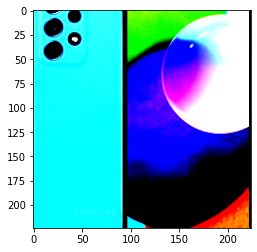

In [25]:
plt.imshow(image.permute(1,2,0))

## Show dataset

In [40]:
def show_dataset(dataset, start_index, count):
    
    indices = np.arange(start_index, start_index+count)
    print(indices)

    size = 5
    rows = 1
    plt.figure(figsize=(count*size,size))
    
    for i, index in enumerate(indices):    

        dataset_item = dataset[index]
        
        image = dataset_item['image']
        text = dataset_item['text']

        plt.subplot(rows,count,i+1)
        plt.grid(False)
        plt.axis('off')
        plt.title(f'Shape: {list(image.shape)}', fontsize=16)
        plt.imshow(image.permute(1,2,0))

        # plt.text(4, 1, text, ha='left', wrap=True)

[0 1 2 3 4]


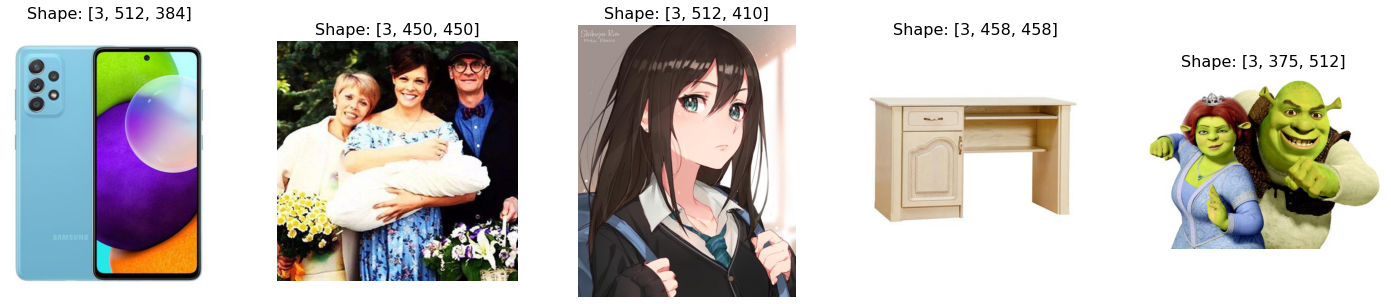

In [41]:
show_dataset(dataset, 0, 5)

In [241]:
def show_dataset_item(dataset, index):
    
    size = 5
    plt.figure(figsize=(size,size))
    
    dataset_item = dataset[index]
        
    image = dataset_item['image']
    text = dataset_item['text']

    for t in text:
        print(t)

    plt.grid(False)
    plt.axis('off')
    plt.title(f'Shape: {list(image.shape)}', fontsize=16)
    plt.imshow(image.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input_ids
attention_mask


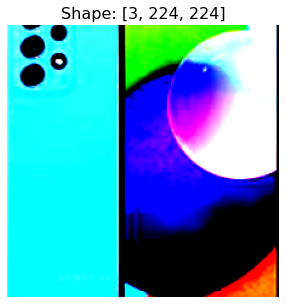

In [242]:
show_dataset_item(dataset, 0)

In [238]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [239]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_dataset_item(dataset, x)

In [240]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=19), Output()), _dom_classes=('widget-…

<function __main__.handle_change(x)>

In [ ]:
images = os.listdir(cfg.path.images_directory)
id_to_remove = np.load(os.path.join(cfg.path.metadata_directory, 'id_to_remove.npy'))
index_to_remove = np.load(os.path.join(cfg.path.metadata_directory, 'index_to_remove.npy'))
len(images), len(index_to_remove), len(id_to_remove), len(images) + len(index_to_remove)

(24627, 1990, 1990, 26617)

# BPEmb

In [ ]:
with open(metadata_file) as json_file:
    json_strings = json_file.readlines()

In [ ]:
len(json_strings), json_strings[0]

(5462418,
 '{"image": 1, "queries": ["samsing a52", "samsung a32", "смартфон samsung galaxy a32 128gb awesome violet", "samsung a 52", "samsung galaxy a32 лаванда"]}\n')

In [52]:
from bpemb import BPEmb

In [53]:
embedding_size: int = 200
vocab_size: int = 200000

bpemb_ru = BPEmb(lang="ru", dim=embedding_size, vs=vocab_size)

In [ ]:
images = os.listdir(images_directory)
len(images)

93

In [ ]:
dataset = I2TDataset(
    metadata_file,
    images_directory,
    tokenizer = bpemb_ru,
    read_jsonlines = False,
    start = 0,
    end = 50,
    randomize = False,
    tqdm_load = True
)

In [ ]:
len(dataset)

50

In [ ]:
# dataset_item

In [81]:
bpemb_ru.encode('samsing a52')

['▁sam', 'sing', '▁a', '00']

In [82]:
bpemb_ru.encode_ids('samsing a52')

[13235, 33493, 449, 4]

# DataLoader

In [17]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader

In [18]:
cfg.data.collate_fn

True

In [20]:
if cfg.data.collate_fn:
    collate_fn = train_dataset.collate_fn
else:
    collate_fn = None
        
train_dataloader = DataLoader(
    train_dataset,
    batch_size=cfg.train.batch_size_train,
    collate_fn=collate_fn,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

In [22]:
dataloader_iter = iter(train_dataloader)

In [23]:
sample_batch = next(dataloader_iter)

In [180]:
# sample_batch

In [182]:
# sample_batch['input_ids'].shape

In [24]:
image_batch = sample_batch['image']
image_batch.shape

torch.Size([4, 3, 224, 224])

In [25]:
text_batch = sample_batch['text']

In [26]:
text_batch

{'ids': tensor([49729,  7506,   699,  8458, 33118,  5168,  7396, 67869,  7221,    55,
         58866,  9184, 28194,  2922, 36679, 37651,  2962,  3230, 13323,   314,
             0,   227,  8939, 59227]),
 'offsets': tensor([ 0,  5, 13, 17])}

# EmbeddingBag

In [49]:
import torch
from torch import nn

In [54]:
embedding_bag = nn.EmbeddingBag.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [55]:
x = embedding_bag(text_batch['ids'], text_batch['offsets'])

In [56]:
x.shape

torch.Size([4, 200])

In [57]:
embedding = nn.Embedding.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [58]:
x = embedding(text_batch['ids'])

In [59]:
x.shape

torch.Size([20, 200])

# Transformers

In [16]:
import transformers

In [61]:
MODEL_PATH = 'DeepPavlov/distilrubert-tiny-cased-conversational' # xlm-roberta-base 'distilbert-base-uncased'

In [62]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_PATH)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/538 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [63]:
tokenizer

PreTrainedTokenizerFast(name_or_path='DeepPavlov/distilrubert-tiny-cased-conversational', vocab_size=100792, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [64]:
metadata[5][1]

['скачать картинки доброе утро мужчине с кофе',
 'доброе утро кофе картинки мужчине',
 'доброе утро шлю тебе кофе для мужчины',
 'кофе для мужчины с добрым утром',
 'твой кофе картинки']

In [65]:
text = metadata[5][1][0]
text

'скачать картинки доброе утро мужчине с кофе'

In [66]:
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)
print(len(tokenized_text))

['скачать', 'картинки', 'доброе', 'утро', 'мужчине', 'с', 'кофе']
7


In [67]:
tokenizer.vocab_size

100792

In [36]:
MAX_LEN = 10

In [37]:
encoded_input = tokenizer(
    text,
#     return_tensors='pt',
#     pad_to_max_length=True,
    truncation='longest_first',
    padding='max_length',
    max_length=MAX_LEN
)
encoded_input

{'input_ids': [0, 170481, 198491, 8190, 103, 118123, 75429, 103, 135, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [102]:
inputs = tokenizer.encode_plus(
    text,
#     add_special_tokens=True,
#     return_attention_masks=False,
    pad_to_max_length=True,
    max_length=MAX_LEN)

In [103]:
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [68]:
model = transformers.AutoModel.from_pretrained(MODEL_PATH)

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [111]:
# model

In [92]:
# MultiHeadSelfAttention

In [104]:
input_ids_tensor = torch.tensor([input_ids])
attention_mask_tensor = torch.tensor([attention_mask])

outputs = model(
    input_ids=input_ids_tensor,
    attention_mask=attention_mask_tensor
)

In [107]:
outputs.last_hidden_state.shape

torch.Size([1, 10, 768])

In [108]:
# eff-net-b0 + distilbert-base-uncased
# ViT

In [32]:
def get_num_of_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [110]:
get_num_of_params(model)

66362880

In [ ]:
# hot to know precision?
model.half() # NO

# I2T

In [71]:
import torch

In [28]:
from system import I2T

In [78]:
model_i2t = I2T(config=cfg)

In [30]:
# model_i2t

In [33]:
get_num_of_params(model_i2t)

64039632

In [34]:
text_encoder = model_i2t.encoders.text.encoder
get_num_of_params(text_encoder)

40243600

In [36]:
# text_encoder

## step model

In [121]:
loss = model_i2t.training_step(sample_batch, 0)
loss

tensor([0, 1, 2, 3])
{'nce_i2t': tensor(7.6112, grad_fn=<NllLossBackward>), 'nce_t2i': tensor(6.5224, grad_fn=<NllLossBackward>), 'nce': tensor(7.0668, grad_fn=<DivBackward0>)}


{'loss': tensor(7.0668, grad_fn=<DivBackward0>)}

In [124]:
loss = model_i2t.training_step(sample_batch, 0)
loss

tensor([1, 3, 2, 0])
{'nce_i2t': tensor(7.6112, grad_fn=<NllLossBackward>), 'nce_t2i': tensor(5.7763, grad_fn=<NllLossBackward>), 'nce': tensor(6.6937, grad_fn=<DivBackward0>)}


{'loss': tensor(6.6937, grad_fn=<DivBackward0>)}

## forward

In [104]:
output = model_i2t(sample_batch)

In [105]:
output['text'].shape, output['image'].shape

(torch.Size([4, 128]), torch.Size([4, 128]))

In [106]:
image_features = output['image']
text_features = output['text']

In [107]:
image_features.shape

torch.Size([4, 128])

In [108]:
logits = model_i2t.gather_logits(output)
logits.shape

torch.Size([4, 4])

In [109]:
logits

tensor([[-0.1274, -0.0963, -0.0213, -0.0068],
        [-0.1675, -0.2100, -0.0595, -0.1726],
        [-0.1827, -0.1601, -0.0830, -0.1931],
        [-0.1143, -0.1799, -0.0448, -0.0756]], grad_fn=<MmBackward>)

In [113]:
num_samples = logits.size()[0]
classes = torch.tensor(np.random.choice(num_samples,num_samples, replace=False))
classes

tensor([2, 1, 3, 0])

In [114]:
# logits[classes][:,classes]

In [115]:
logits_2 = image_features[classes] @ text_features.T
logits_2

tensor([[-0.1827, -0.1601, -0.0830, -0.1931],
        [-0.1675, -0.2100, -0.0595, -0.1726],
        [-0.1143, -0.1799, -0.0448, -0.0756],
        [-0.1274, -0.0963, -0.0213, -0.0068]], grad_fn=<MmBackward>)

In [116]:
logits_2.T

tensor([[-0.1827, -0.1675, -0.1143, -0.1274],
        [-0.1601, -0.2100, -0.1799, -0.0963],
        [-0.0830, -0.0595, -0.0448, -0.0213],
        [-0.1931, -0.1726, -0.0756, -0.0068]], grad_fn=<PermuteBackward>)

# Run

In [208]:
!pwd

/Users/michaelka/Developer/ml/projects/ycup21/main


In [82]:
!python main.py path=local mode=debug train.trainer_params.gpus=0 +experiment=bert

train:
  batch_size_train: ${mode.batch_size_train}
  batch_size_val: ${mode.batch_size_val}
  trainer_params:
    gpus: 0
    deterministic: true
    num_sanity_val_steps: 0
    checkpoint_callback: false
    max_epochs: ${mode.max_epochs}
    log_every_n_steps: ${mode.log_every_n_steps}
data:
  dataloader_workers: ${path.dataloader_workers}
  collate_fn: false
  split_ratio: 0.9
  metadata:
    metadata_directory: ${path.metadata_directory}
    dataset_size: ${mode.dataset_size}
  train:
    images_directory: ${path.images_directory}
    randomize: true
  val:
    images_directory: ${path.images_directory}
    randomize: false
tokenizer: bert
model:
  text:
    _target_: model.ModalityEncoder
    output_dim: ${model.joint_dim}
    normalize: true
    encoder:
      _target_: model.BERTModel
      model_name: xlm-roberta-base
  joint_dim: 128
  image:
    _target_: model.ModalityEncoder
    output_dim: ${model.joint_dim}
    normalize: true
    encoder:
      _target_: model.ImageMode